# Movie Recommendation System Benchmarking
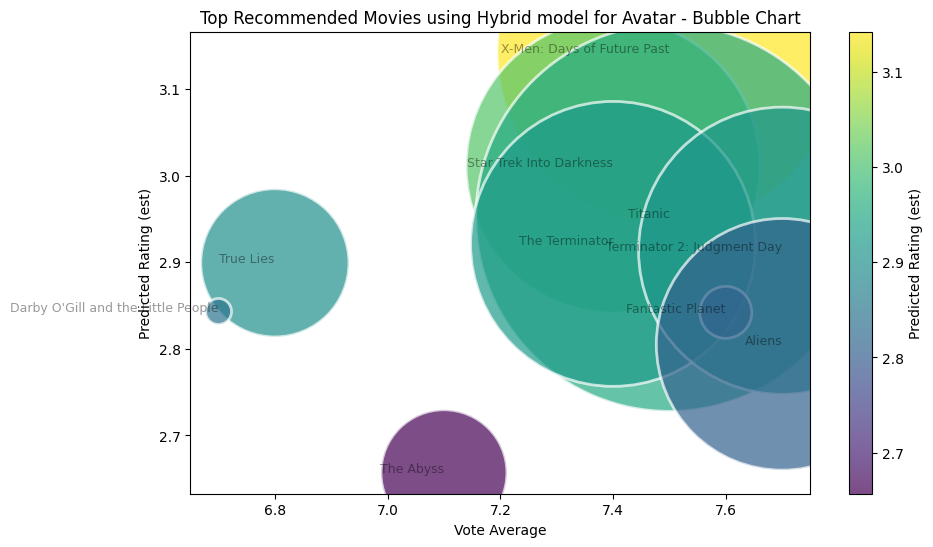 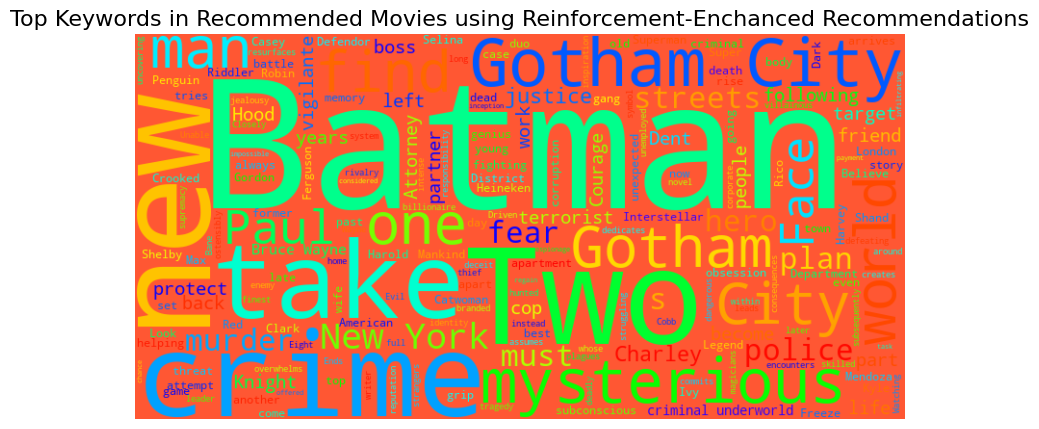

In this notebook, I will implement various recommendation algorithms, including content-based, popularity-based, collaborative filtering approaches, and the most awaited NetFlix's Reinforcement-Learning enhanced Recommendation model. The goal is to build an ensemble model that combines these algorithms to deliver a robust recommendation system. Two MovieLens datasets are available for this project:

### Full Dataset
- **Ratings**: 26 million
- **Tags**: 750,000 tag applications
- **Movies**: 45,000
- **Users**: 270,000
- **Tag Genome**: Includes 12 million relevance scores across 1,100 tags

### Small Dataset
- **Ratings**: 100,000
- **Tags**: 1,300 tag applications
- **Movies**: 9,000
- **Users**: 700

To manage computational limitations, the **Full Dataset** will be used to build a simple recommendation model, while all **personalized recommenders** will utilize the **Small Dataset**. 

The project will begin by developing a simple recommender system, followed by personalized recommendation models.


In [73]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from datetime import datetime

import warnings; warnings.simplefilter('ignore')

### Simple Recommender

The Simple Recommender provides generalized recommendations to all users, focusing on movie popularity and, optionally, genre. The core idea is that movies with higher popularity and critical acclaim are more likely to appeal to the average viewer. This model does not tailor recommendations to individual user preferences.

Implementing this model is straightforward: we simply sort movies by ratings and popularity, displaying the top results. Additionally, we can include a genre filter to showcase the top movies within a specified genre.


In [18]:
md = pd. read_csv('movies_metadata.csv')
md.head()

adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1  When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2  A family wedding reignites the ancient feud be...  ...   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4  Just when George Banks has recovered from his ...  ...   1995-02-10   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [19]:
# md = pd.read_csv('movies_metadata.csv')
# md_cleaned = preprocess_movies_metadata(md)
md_cleaned

adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
3      False                                                NaN  16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
5      False                                                NaN  60000000   
...      ...                                                ...       ...   
45381  False                                                NaN         0   
45401  False                                                NaN         0   
45409  False                                                NaN    800000   
45412  False                                                NaN   2000000   
45422  False                                                NaN   5000000   

                                 genres    imdb_id original_language  \
0           [Animation, Comedy, Family]  tt0114709                en   
1          [Adventure, Fantasy, Family]  tt0113497                en   
3              [Comedy, Drama, Romance]  tt0114885                en   
4                              [Comedy]  tt0113041                en   
5      [Action, Crime, Drama, Thriller]  tt0113277                en   
...                                 ...        ...               ...   
45381       [Horror, Thriller, Mystery]  tt2400314                ru   
45401         [Drama, History, Mystery]  tt1197626                ru   
45409                   [Comedy, Drama]  tt0933361                en   
45412                  [Romance, Drama]  tt1718881                en   
45422  [Action, Comedy, Crime, Foreign]  tt1110037                ru   

                    original_title  \
0                        Toy Story   
1                          Jumanji   
3                Waiting to Exhale   
4      Father of the Bride Part II   
5                             Heat   
...                            ...   
45381                 Vladeniye 18   
45401                         Чудо   
45409                       Dikari   
45412                   Про любоff   
45422                     Антидурь   

                                                overview popularity  \
0      Led by Woody, Andy's toys live happily in his ...  21.946943   
1      When siblings Judy and Peter discover an encha...  17.015539   
3      Cheated on, mistreated and stepped on, the wom...   3.859495   
4      Just when George Banks has recovered from his ...   8.387519   
5      Obsessive master thief, Neil McCauley leads a ...  17.924927   
...                                                  ...        ...   
45381  Sveta and Maxim, a happy newlyweds, are moving...   0.217441   
45401  The film is based on real events that took pla...   0.436028   
45409  The sea, August, interesting and simple people...   0.903061   
45412  У девушки Даши, приехавшей с подругой «покорят...   0.121844   
45422  Failing to complete an important assignment wi...   0.039793   

                            poster_path  ...      revenue runtime  \
0      /rhIRbceoE9lR4veEXuwCC2wARtG.jpg  ...  373554033.0    81.0   
1      /vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg  ...  262797249.0   104.0   
3      /16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg  ...   81452156.0   127.0   
4      /e64sOI48hQXyru7naBFyssKFxVd.jpg  ...   76578911.0   106.0   
5      /zMyfPUelumio3tiDKPffaUpsQTD.jpg  ...  187436818.0   170.0   
...                                 ...  ...          ...     ...   
45381  /aU51pWVHtLVsFOJA88Gp7F5l1CY.jpg  ...     320395.0    90.0   
45401  /AjXZQPdV5PUibMqVPXVFCZ4VK4N.jpg  ...      50656.0   110.0   
45409  /t14Sb80sXJCAa3ERs0UoheXhSD9.jpg  ...    1328612.0   100.0   
45412  /f8umkhHSctmiU4hw7U1IK1JxFT7.jpg  ...    1268793.0   107.0   
45422  /f5XOYgsF4oCTz0A4gY8qD9g3l5y.jpg  ...    1413000.0    91.0   

          spoken_languages    status  \
0                [English]  Released  

In [20]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])


To create our Top Movies Chart, I’ll use TMDB ratings along with IMDB's weighted rating formula. This formula is expressed as:

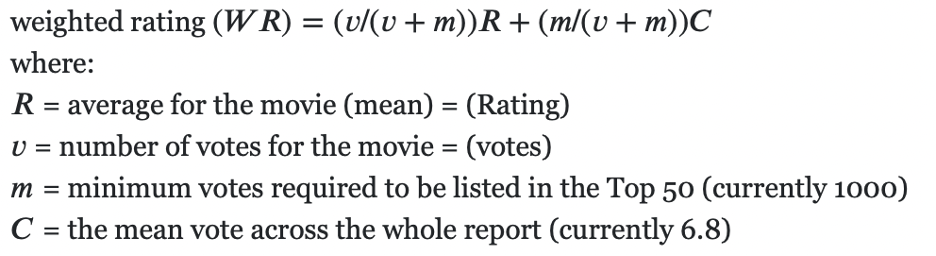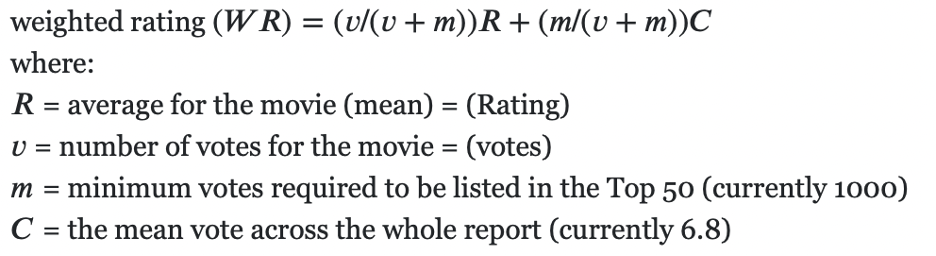

Next, we need to determine an appropriate value for \( m \). We’ll set \( m \) to the 95th percentile of votes, meaning a movie must have more votes than at least 95% of the movies in our dataset to qualify for the chart.

With this setup, I’ll build an overall Top 250 Chart and define a function to generate charts based on specific genres. Let's get started!


In [21]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

### Calculating Mean Vote (C)

In this section, we calculate the mean rating across all movies with valid ratings, denoted as **C**. This value represents the average movie rating and is used in our weighted rating formula to rank movies more accurately.

- We filter out movies with missing vote counts and average ratings.
- The mean of these valid ratings is calculated and stored as **C**.

This baseline average rating helps us ensure that our ranking considers both popularity and quality, creating a more reliable Top Movies Chart.


In [22]:
m = vote_counts.quantile(0.95)
m


434.0

### Determining Minimum Vote Threshold (m)

Here, we calculate the minimum number of votes required for a movie to be included in our Top Movies Chart, represented as **m**. 

- We set the threshold at the 95th percentile of vote counts, meaning a movie must have more votes than at least 95% of the movies in the dataset to qualify.
- This ensures that only movies with significant audience engagement are featured, improving the reliability and relevance of our recommendations.

This **m** threshold filters out movies with lower popularity, allowing us to focus on highly-rated films with substantial viewership.


In [23]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [24]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

To be eligible for the chart, a movie must have at least 434 votes on TMDB. The average rating for a movie on TMDB is 5.244 out of 10. A total of 2,274 movies meet these criteria and qualify for our chart.


In [25]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)



In [26]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)



In [27]:
qualified = qualified.sort_values('wr', ascending=False).head(250)



In [28]:
# TopMMovies 
qualified.head(10)

title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
22879                                       Interstellar  2014       11187   
2843                                          Fight Club  1999        9678   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
292                                         Pulp Fiction  1994        8670   
314                             The Shawshank Redemption  1994        8358   
7000       The Lord of the Rings: The Return of the King  2003        8226   
351                                         Forrest Gump  1994        8147   
5814               The Lord of the Rings: The Two Towers  2002        7641   

       vote_average  popularity  \
15480             8   29.108149   
12481             8  123.167259   
22879             8   32.213481   
2843              8   63.869599   
4863              8   32.070725   
292               8  140.950236   
314               8   51.645403   
7000              8   29.324358   
351               8   48.307194   
5814              8   29.423537   

                                                  genres        wr  
15480  [Action, Thriller, Science Fiction, Mystery, A...  7.917588  
12481                   [Drama, Action, Crime, Thriller]  7.905871  
22879                [Adventure, Drama, Science Fiction]  7.897107  
2843                                             [Drama]  7.881753  
4863                        [Adventure, Fantasy, Action]  7.871787  
292                                    [Thriller, Crime]  7.868660  
314                                       [Drama, Crime]  7.864000  
7000                        [Adventure, Fantasy, Action]  7.861927  
351                             [Comedy, Drama, Romance]  7.860656  
5814                        [Adventure, Fantasy, Action]  7.851924

### Top Rankings: Christopher Nolan's Influence

Our chart places three Christopher Nolan masterpieces—**Inception**, **The Dark Knight**, and **Interstellar**—right at the top. This highlights a clear TMDB user preference for certain genres and directors.

### Creating Genre-Specific Charts

Now, let’s develop a function to create tailored charts for specific genres. To broaden our analysis, we’ll adjust our criteria to the **85th percentile** instead of the default 95th, allowing for a richer, more inclusive view of movie preferences.


In [29]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)



In [30]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

### Let’s See Our Method in Action: Top 15 Romance Movies

Although **Romance** is one of the most popular genres, it barely appeared in our generic top chart. Let’s now display the **Top 15 Romance Movies** to see how our method highlights popular titles within this genre.

#### Top Romance Movies


In [31]:
build_chart('Romance').head(10)

title  year  vote_count  vote_average popularity  \
10309  Dilwale Dulhania Le Jayenge  1995         661             9  34.457024   
351                   Forrest Gump  1994        8147             8  48.307194   
876                        Vertigo  1958        1162             8   18.20822   
40251                   Your Name.  2016        1030             8  34.461252   
883               Some Like It Hot  1959         835             8  11.845107   
1132               Cinema Paradiso  1988         834             8  14.177005   
19901                     Paperman  2012         734             8   7.198633   
37863                  Sing Street  2016         669             8  10.672862   
882                  The Apartment  1960         498             8  11.994281   
38718               The Handmaiden  2016         453             8  16.727405   

             wr  
10309  8.565285  
351    7.971357  
876    7.811667  
40251  7.789489  
883    7.745154  
1132   7.744878  
19901  7.713951  
37863  7.689483  
882    7.599317  
38718  7.566166

### Top Romance Movies

According to our metrics, the **top romance movie** is Bollywood's *Dilwale Dulhania Le Jayenge*. Close behind are *Forrest Gump* in second place and *Vertigo* in third—both iconic films that exemplify the enduring charm of romance in cinema.


### Content-Based Recommender

The recommender we previously built has some notable limitations. It provides the same recommendations to everyone, regardless of individual preferences. For instance, a person who loves romantic movies (and dislikes action) might not enjoy most of the titles in our Top 15 Chart. Even looking at genre-specific charts may not yield the most suitable recommendations for them.

Consider someone who loves *Dilwale Dulhania Le Jayenge*, *My Name is Khan*, and *Kabhi Khushi Kabhie Gham*. This suggests a preference for Shahrukh Khan’s movies and Karan Johar’s direction. However, even within the romance chart, these may not appear as the top recommendations.

To create more personalized suggestions, I will build a recommendation engine that finds movies similar to a particular title a user enjoys by calculating similarity based on selected attributes. Since this engine relies on movie metadata, it is an example of **Content-Based Filtering**.

I’ll develop two content-based recommenders based on:

1. **Movie Overviews and Taglines**
2. **Movie Cast, Crew, Keywords, and Genre**

Additionally, due to computing constraints, I’ll be using a subset of the complete movie dataset.


In [45]:
links_small = pd.read_csv('links_small.csv')
links_small.head(10)

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0
5        6  113277    949.0
6        7  114319  11860.0
7        8  112302  45325.0
8        9  114576   9091.0
9       10  113189    710.0

In [46]:
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [48]:
#md = md.drop([19730, 29503, 35587])



In [49]:
#Check EDA Notebook for how and why I got these indices.
md['id'] = md['id'].astype('int')



In [50]:
smd = md[md['id'].isin(links_small)]
smd.shape



(9099, 25)

Our small movie metadata dataset contains **9,099 movies**, making it five times smaller than our original dataset of **45,000 movies**.

### Movie Description-Based Recommender

We’ll start by building a recommender that uses **movie descriptions and taglines** to generate suggestions. Since we don’t have a quantitative metric to evaluate its performance, we’ll assess the effectiveness of this recommender qualitatively.


In [77]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [78]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])


In [79]:
tfidf_matrix.shape



(9219, 268124)

### Cosine Similarity

To measure the similarity between two movies, we’ll use **Cosine Similarity**, which provides a numeric value representing how similar two items are. Mathematically, it is defined as:

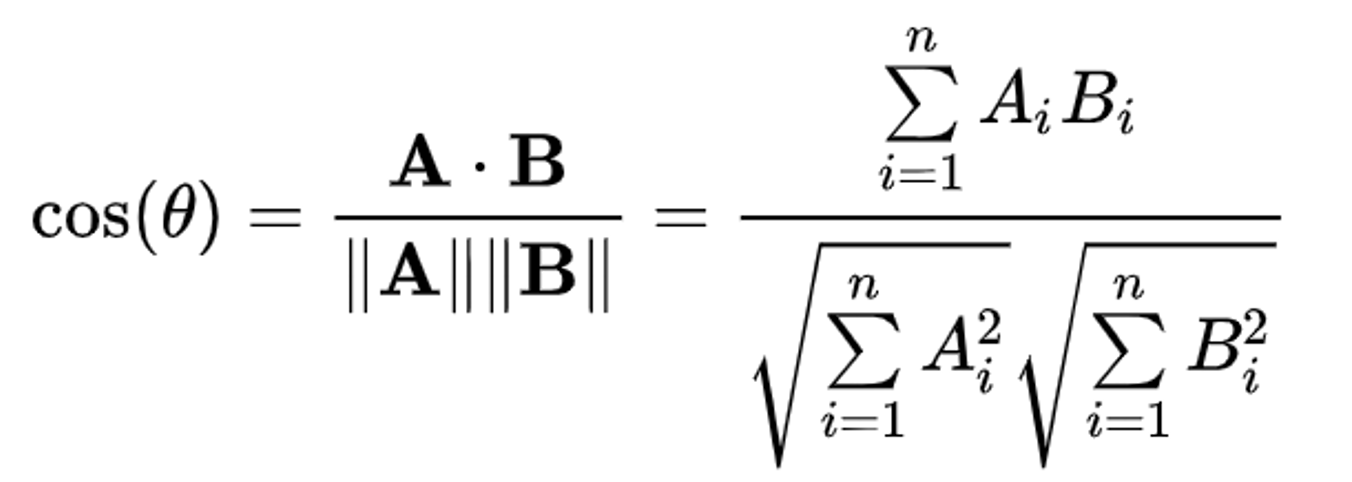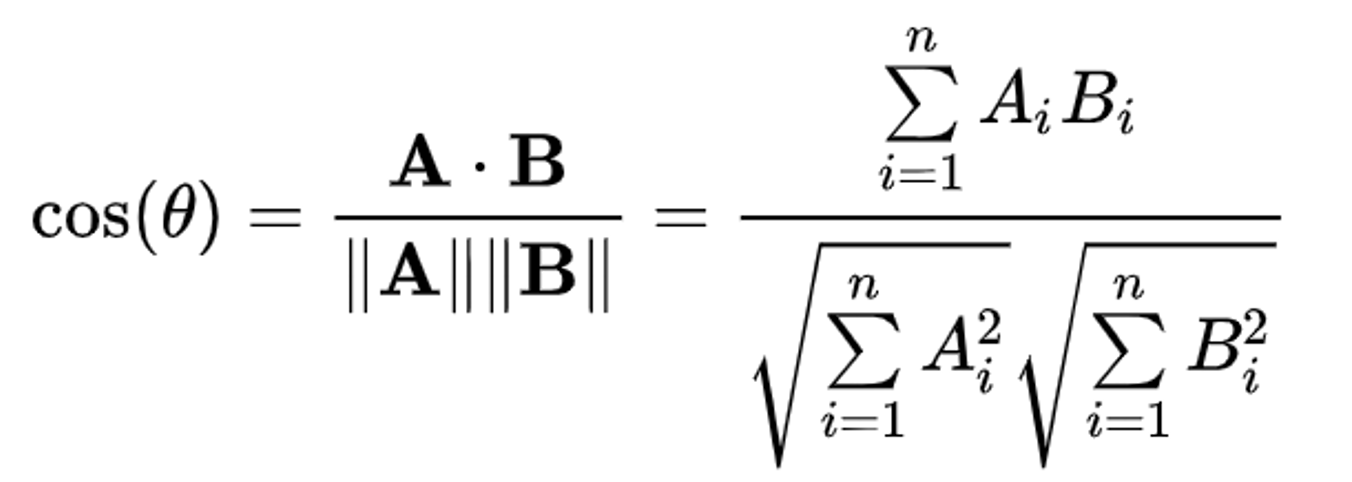


Since we are using the **TF-IDF Vectorizer**, calculating the dot product will directly yield the Cosine Similarity Score. For efficiency, we’ll use `sklearn`'s `linear_kernel` instead of `cosine_similarity`, as it computes this score faster.


In [80]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [81]:
cosine_sim[0]



array([1.        , 0.00681816, 0.        , ..., 0.        , 0.        ,
       0.        ])

With our pairwise **cosine similarity matrix** for all movies in the dataset ready, the next step is to create a function that returns the **30 most similar movies** based on the cosine similarity scores.


In [82]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])



In [83]:
print(smd.columns)

Index(['index', 'adult', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'year', 'cast', 'crew', 'keywords',
       'description'],
      dtype='object')


In [84]:
def get_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 30 most similar movies (excluding the first one, which is the movie itself)
    sim_scores = sim_scores[1:31]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Retrieve the titles of the recommended movies
    recommended_titles = titles.iloc[movie_indices]
    
    # Create a single string with the descriptions of the recommended movies for the word cloud
    text = ' '.join(smd.iloc[movie_indices]['description'].tolist())
    
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return recommended_titles


We’re all set! Let’s now retrieve the **top recommendations** for a few movies and assess the quality of these suggestions.


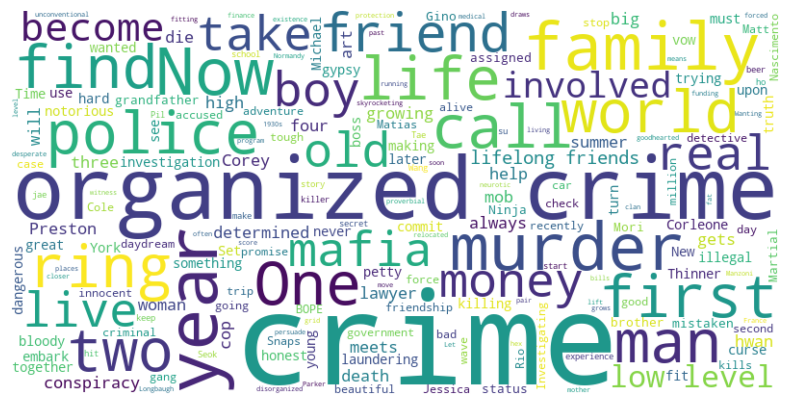

4217                         Johnny Dangerously
3120                         The Way of the Gun
621                                     Thinner
8450                                 The Family
695                               The Godfather
6243                      The Constant Gardener
7190                          The International
3627                              Harlem Nights
7048    The Sisterhood of the Traveling Pants 2
6440                                Renaissance
Name: title, dtype: object

In [85]:
get_recommendations('Made').head(10)



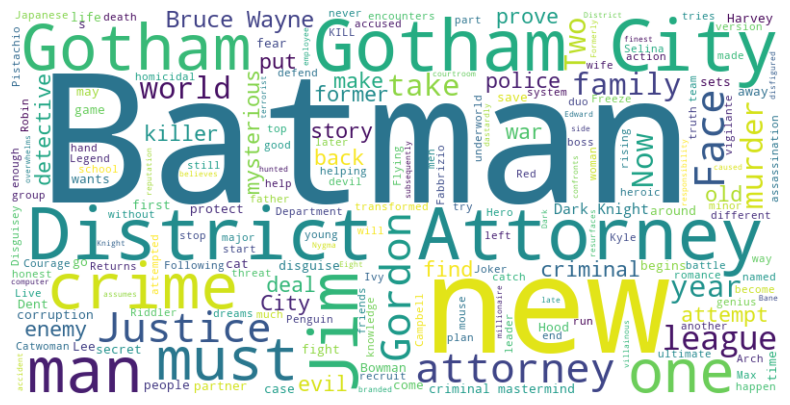

7991                      The Dark Knight Rises
132                              Batman Forever
1122                             Batman Returns
8290    Batman: The Dark Knight Returns, Part 2
7619                 Batman: Under the Red Hood
524                                      Batman
7961                           Batman: Year One
2591               Batman: Mask of the Phantasm
2708                                        JFK
8225    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [86]:
get_recommendations('The Dark Knight').head(10)



### Evaluating Recommendations for *The Dark Knight*

Our system successfully recognizes *The Dark Knight* as part of the Batman series and suggests other Batman films as top recommendations. However, this approach falls short in relevance for most users, as it doesn’t consider crucial features like **cast, crew, director,** and **genre**—key factors that influence a movie’s appeal and popularity. For instance, a fan of *The Dark Knight* likely enjoys it more due to **Christopher Nolan’s** direction and might not appreciate *Batman Forever* or other lesser-regarded titles in the Batman franchise.

### Moving to a Metadata-Based Recommender

To provide more meaningful recommendations, we’ll incorporate richer metadata beyond just the overview and tagline. In the next section, we’ll develop a more advanced recommender that includes **genre, keywords, cast,** and **crew** for improved suggestions.

#### Preparing Data for a Metadata-Based Recommender

To build our comprehensive metadata-based content recommender, we’ll begin by merging our current dataset with additional **crew** and **keyword** datasets. Let’s start by preparing this data.


In [64]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [66]:
credits.head(10)

cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   
5  [{'cast_id': 25, 'character': 'Lt. Vincent Han...   
6  [{'cast_id': 1, 'character': 'Linus Larrabee',...   
7  [{'cast_id': 2, 'character': 'Tom Sawyer', 'cr...   
8  [{'cast_id': 1, 'character': 'Darren Francis T...   
9  [{'cast_id': 1, 'character': 'James Bond', 'cr...   

                                                crew     id  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862  
5  [{'credit_id': '52fe4292c3a36847f802916d', 'de...    949  
6  [{'credit_id': '52fe44959251416c75039da9', 'de...  11860  
7  [{'credit_id': '52fe46bdc3a36847f810f797', 'de...  45325  
8  [{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...   9091  
9  [{'credit_id': '52fe426ec3a36847f801e14b', 'de...    710

In [67]:
keywords.head(10)

id                                           keywords
0    862  [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1   8844  [{'id': 10090, 'name': 'board game'}, {'id': 1...
2  15602  [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3  31357  [{'id': 818, 'name': 'based on novel'}, {'id':...
4  11862  [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
5    949  [{'id': 642, 'name': 'robbery'}, {'id': 703, '...
6  11860  [{'id': 90, 'name': 'paris'}, {'id': 380, 'nam...
7  45325                                                 []
8   9091  [{'id': 949, 'name': 'terrorist'}, {'id': 1562...
9    710  [{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam...

In [68]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')



In [69]:
md.shape

(45463, 25)

In [71]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [72]:
smd = md[md['id'].isin(links_small)]
smd.shape



(9219, 28)

With **cast, crew, genres,** and **credits** all consolidated into a single DataFrame, let’s refine this data based on the following insights:

- **Crew**: From the crew data, we’ll focus solely on the **director**, as this role significantly shapes the movie's style and feel, whereas other crew members have a lesser impact on the audience’s perception.

- **Cast**: Selecting the right cast members requires a bit more nuance. Minor roles and lesser-known actors don’t heavily influence opinions of a movie, so we’ll prioritize **major characters**. Specifically, we’ll select the **top 3 actors** listed in the credits for each film.


In [87]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))



In [88]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan



In [89]:
smd['director'] = smd['crew'].apply(get_director)



In [90]:
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)



In [91]:
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])



### Building a "Hacky" Metadata-Based Recommender

My approach for this recommender is intentionally straightforward: I’ll create a **metadata dump** for each movie, which combines information on **genres, director, main actors,** and **keywords**. Using this metadata, I’ll employ a **Count Vectorizer** to generate a count matrix, similar to the process we used for the Description Recommender. The rest follows as before—we’ll compute **cosine similarities** and recommend movies that are most alike.

#### Steps for Preparing Genres and Credits Data

1. **Normalize Text**: Strip spaces and convert all text to lowercase across all features. This avoids confusing similar names, like **Johnny Depp** and **Johnny Galecki**.

2. **Weighting the Director**: To emphasize the importance of the director, we’ll mention the **director’s name three times** in the metadata, giving it more weight compared to other cast members.


In [92]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])



In [93]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])



### Processing Keywords

Before incorporating keywords into our recommender, we’ll perform a bit of preprocessing. First, we’ll calculate the **frequency counts** for each keyword in the dataset to understand their prominence and filter out less relevant ones if necessary.


In [94]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'



In [95]:
s = s.value_counts()
s[:5]

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

Keywords appear with frequencies ranging from **1 to 610**. To keep our data meaningful, we’ll **remove keywords that occur only once** as they provide minimal value. Finally, we’ll **apply stemming** to each keyword, ensuring that similar words like "dog" and "dogs" are treated as the same term.


In [96]:
s = s[s > 1]

In [97]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [98]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words



In [99]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [100]:
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [102]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])



In [103]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)



In [104]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])



### Reusing the Recommendation Function

We’ll reuse the `get_recommendations` function we created earlier. With our updated cosine similarity scores, we can expect different—and hopefully improved—results. Let’s test it with *The Dark Knight* once more and see what recommendations we get this time.


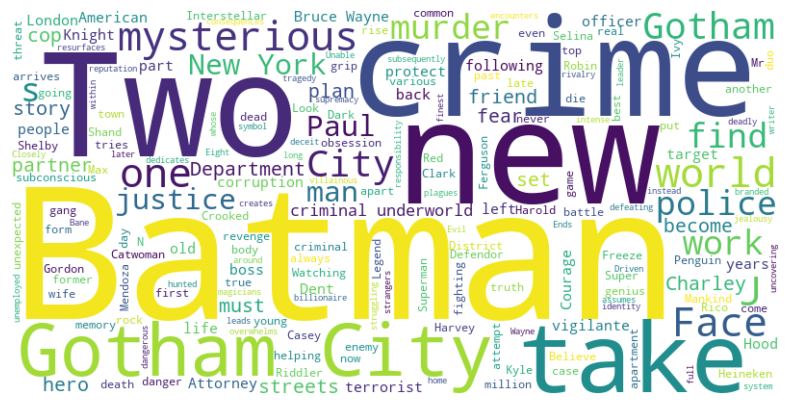

7991         The Dark Knight Rises
6186                 Batman Begins
6587                  The Prestige
2077                     Following
7608                     Inception
4125                      Insomnia
3373                       Memento
8573                  Interstellar
7619    Batman: Under the Red Hood
1122                Batman Returns
Name: title, dtype: object

In [105]:
get_recommendations('The Dark Knight').head(10)



I’m far more satisfied with the recommendations this time! The engine has effectively recognized other **Christopher Nolan** films, thanks to the high weight we assigned to the director. Movies like *Batman Begins*, *The Prestige*, and *The Dark Knight Rises* now appear among the top suggestions—titles I thoroughly enjoyed alongside *The Dark Knight*.

### Experimenting with Feature Weights

There’s plenty of room for experimentation with this recommender engine. We can try adjusting the weights for different features (like directors, actors, and genres), limiting the number of keywords used in the "metadata soup," prioritizing genres by frequency, filtering for movies in the same language, and more.

Now, let’s test the recommendations for another movie—*Mean Girls*.


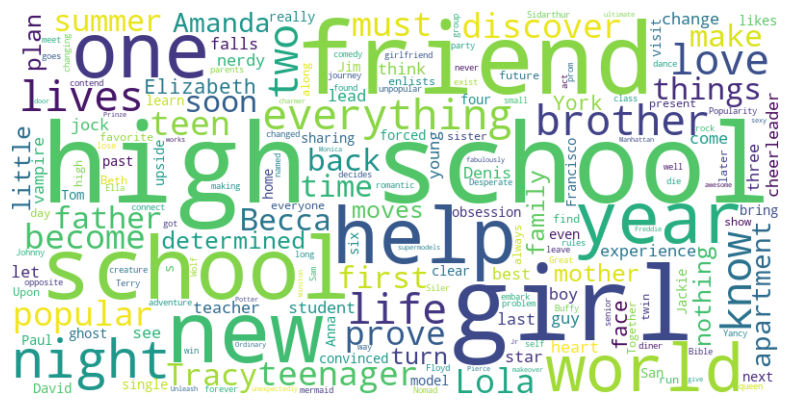

3311               Head Over Heels
4735                 Freaky Friday
1321              The House of Yes
6245              Just Like Heaven
7865         Mr. Popper's Penguins
7292    Ghosts of Girlfriends Past
6923     The Spiderwick Chronicles
8855                      The DUFF
6662         It's a Boy Girl Thing
7333       I Love You, Beth Cooper
Name: title, dtype: object

In [106]:
get_recommendations('Mean Girls').head(10)



In [107]:
import random

# Define a custom color function for the word cloud
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(%d, 100%%, 50%%)" % random.randint(0, 255)

def improved_recommendations(title):
    # Get the index of the movie that matches the title
    idx = indices[title]
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 25 most similar movies (excluding the first one, which is the movie itself)
    sim_scores = sim_scores[1:26]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Select relevant columns for the recommended movies
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'description']]
    
    # Calculate mean vote and minimum vote threshold
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    
    # Filter and calculate the weighted rating
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    
    # Generate word cloud for the recommended movies' descriptions
    text = ' '.join(qualified['description'].fillna('').tolist())
    wordcloud = WordCloud(
        width=800, height=400, background_color='black', colormap='cool', 
        color_func=custom_color_func, contour_color='white', contour_width=2
    ).generate(text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return qualified


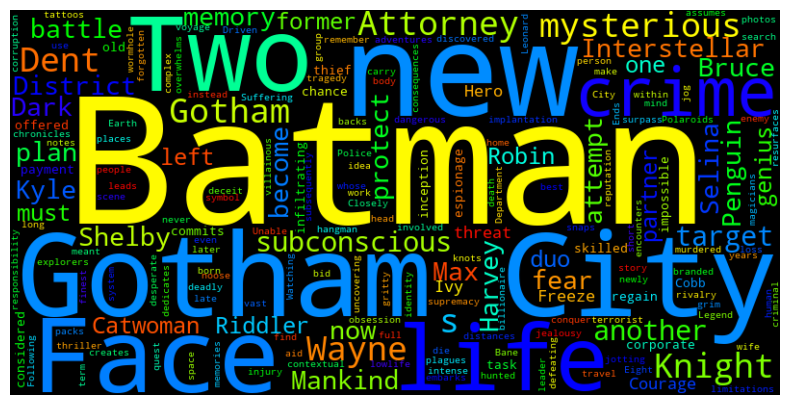

title  vote_count  vote_average  year  \
7608                           Inception       14075             8  2010   
8573                        Interstellar       11187             8  2014   
6587                        The Prestige        4510             8  2006   
3373                             Memento        4168             8  2000   
7991               The Dark Knight Rises        9263             7  2012   
6186                       Batman Begins        7511             7  2005   
1122                      Batman Returns        1706             6  1992   
132                       Batman Forever        1529             5  1995   
9004  Batman v Superman: Dawn of Justice        7189             5  2016   
1252                      Batman & Robin        1447             4  1997   

                                            description        wr  
7608  Cobb, a skilled thief who commits corporate es...  7.917588  
8573  Interstellar chronicles the adventures of a gr...  7.897107  
6587  A mysterious story of two magicians whose inte...  7.758148  
3373  Suffering short-term memory loss after a head ...  7.740175  
7991  Following the death of District Attorney Harve...  6.921448  
6186  Driven by tragedy, billionaire Bruce Wayne ded...  6.904127  
1122  Having defeated the Joker, Batman now faces th...  5.846862  
132   The Dark Knight of Gotham City confronts a das...  5.054144  
9004  Fearing the actions of a god-like Super Hero l...  5.013943  
1252  Along with crime-fighting partner Robin and ne...  4.287233

In [108]:
improved_recommendations('The Dark Knight')



Next, let’s check the improved recommendations for *Mean Girls*.


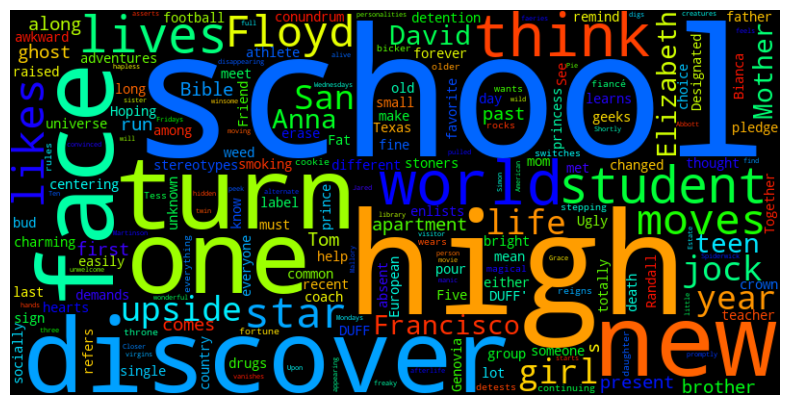

title  vote_count  vote_average  year  \
1539                       The Breakfast Club        2189             7  1985   
390                        Dazed and Confused         588             7  1993   
8855                                 The DUFF        1372             6  2015   
3696                     The Princess Diaries        1063             6  2001   
4735                            Freaky Friday         919             6  2003   
6245                         Just Like Heaven         595             6  2005   
6923                The Spiderwick Chronicles         593             6  2008   
7450  American Pie Presents: The Book of Love         454             5  2009   
7292               Ghosts of Girlfriends Past         716             5  2009   
7865                    Mr. Popper's Penguins         775             5  2011   

                                            description        wr  
1539  Five high school students, all different stere...  6.709602  
390   The adventures of a group of Texas teens on th...  6.254682  
8855  Bianca's universe turns upside down when she l...  5.818541  
3696  A socially awkward but very bright 15-year-old...  5.781086  
4735  Mother and daughter bicker over everything -- ...  5.757786  
6245  Shortly after David Abbott moves into his new ...  5.681521  
6923  Upon moving into the run-down Spiderwick Estat...  5.680901  
7450  Ten years after the first American Pie movie, ...  5.119690  
7292  When notorious womanizer Connor Mead attends h...  5.092422  
7865  Jim Carrey stars as Tom Popper, a successful b...  5.087912

In [117]:
improved_recommendations('Mean Girls')



In our current approach, we introduce a **reinforcement learning (RL) agent** that dynamically allocates resources—such as **CPU count** and **batch size**—to maximize the throughput of the recommendation pipeline. This design is inspired by advanced optimization techniques from recent research on data pipeline optimization for deep learning recommenders, such as Netflix’s *InTune*. This RL-driven approach enables us to:

- **Optimize Resource Allocation**: The RL agent intelligently adjusts CPU count and batch size to balance workload distribution effectively.
- **Increase Efficiency**: By leveraging real-time feedback from pipeline performance, the agent reduces idle time and enhances processing speed.
- **Adapt to Different Scenarios**: This adaptive approach ensures that the recommendation engine can scale and perform optimally under various configurations, eliminating the need for manual adjustments.


In [158]:
import random

class RLAgent:
    def __init__(self):
        self.best_config = {'cpu_count': 1, 'batch_size': 16}
        self.best_reward = -float('inf')
    
    def select_action(self, state):
        # Here, we randomly decide to increase or decrease CPU/batch count
        # In a real implementation, this would use a policy to choose actions
        action = {
            'cpu_increment': random.choice([-1, 1]),  # Either decrease or increase CPU
            'batch_increment': random.choice([-4, 4])  # Either decrease or increase batch size
        }
        return action

    def update(self, state, reward):
        # Update the best configuration if this state yields a better reward
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_config = state.copy()

    def get_best_configuration(self):
        return self.best_config


def calculate_reward(latency, throughput):
    # Hypothetical reward function
    return throughput / (latency + 1)


def simulate_pipeline_performance(cpu_count, batch_size):
    # Placeholder function to simulate pipeline latency and throughput
    # Replace with actual logic for your recommendation model
    latency = max(0.1, 10 / cpu_count)  # Simulate lower latency with more CPUs
    throughput = batch_size * cpu_count  # Simulate higher throughput with more resources
    return latency, throughput


def rl_improved_recommendations(title):
    # Initialize reinforcement learning agent
    agent = RLAgent()
    
    # Get index of the movie that matches the title
    idx = indices[title]
    
    # Pairwise similarity scores of all movies with the target movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    
    # Movie indices
    movie_indices = [i[0] for i in sim_scores]
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'description']]
    
    # Reinforcement learning for dynamic resource optimization
    state = {
        'cpu_count': 1,  # Initial CPU allocation
        'batch_size': 16,  # Initial batch size
    }
    
    # RL-based optimization
    for _ in range(10):  # Simulation steps
        action = agent.select_action(state)  # Agent selects an action based on the current state
        state['cpu_count'] = max(1, state['cpu_count'] + action['cpu_increment'])
        state['batch_size'] = max(1, state['batch_size'] + action['batch_increment'])
        
        # Calculate reward based on throughput and latency improvements
        latency, throughput = simulate_pipeline_performance(state['cpu_count'], state['batch_size'])
        reward = calculate_reward(latency, throughput)
        
        # Update the agent with the new reward
        agent.update(state, reward)
    
    # Once optimized, apply the best configuration for recommendations
    best_config = agent.get_best_configuration()
    print(f"Best configuration found: CPU Count = {best_config['cpu_count']}, Batch Size = {best_config['batch_size']}")

    # Generate Word Cloud for recommended movie descriptions
    text = ' '.join(movies['description'].fillna('').tolist())
    wordcloud = WordCloud(
        width=800, height=400, background_color='#FF5733', colormap='magma', 
        color_func=lambda *args, **kwargs: "hsl(%d, 100%%, 50%%)" % random.randint(0, 255),
        contour_color='brown', contour_width=2
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Top Keywords in Recommended Movies using Reinforcement-Enchanced Recommendations', fontsize=16) 
    plt.show()
    
    return movies

Best configuration found: CPU Count = 6, Batch Size = 36


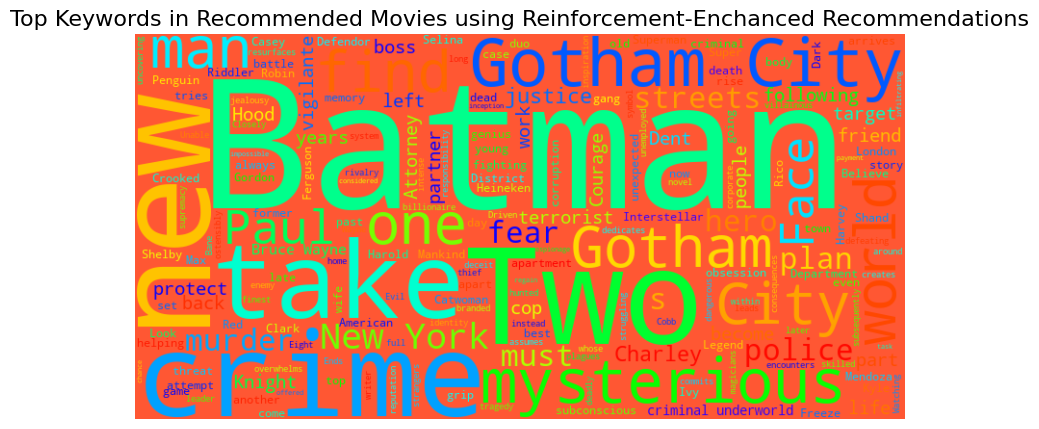

title  vote_count  vote_average  year  \
7991               The Dark Knight Rises      9263.0           7.6  2012   
6186                       Batman Begins      7511.0           7.5  2005   
6587                        The Prestige      4510.0           8.0  2006   
2077                           Following       363.0           7.2  1998   
7608                           Inception     14075.0           8.1  2010   
4125                            Insomnia      1181.0           6.8  2002   
3373                             Memento      4168.0           8.1  2000   
8573                        Interstellar     11187.0           8.1  2014   
7619          Batman: Under the Red Hood       459.0           7.6  2010   
1122                      Batman Returns      1706.0           6.6  1992   
8899             Kidnapping Mr. Heineken       193.0           5.8  2015   
5907                            Thursday        84.0           7.0  1998   
1252                      Batman & Robin      1447.0           4.2  1997   
9004  Batman v Superman: Dawn of Justice      7189.0           5.7  2016   
4005                The Long Good Friday        87.0           7.1  1980   
5773                         Point Blank        97.0           7.1  1967   
7322     Gangster's Paradise: Jerusalema        16.0           6.8  2008   
7517                         Harry Brown       351.0           6.7  2009   
7538                            Defendor       197.0           6.5  2009   
7961                    Batman: Year One       255.0           7.1  2011   
2746                        Death Wish 3        68.0           6.1  1985   
132                       Batman Forever      1529.0           5.2  1995   
2123                            Superman      1042.0           6.9  1978   
2440                          Nighthawks        87.0           6.4  1981   
5070                        The Enforcer        21.0           7.4  1951   

                                            description  
7991  Following the death of District Attorney Harve...  
6186  Driven by tragedy, billionaire Bruce Wayne ded...  
6587  A mysterious story of two magicians whose inte...  
2077  A struggling, unemployed young writer takes to...  
7608  Cobb, a skilled thief who commits corporate es...  
4125  Two Los Angeles homicide detectives are dispat...  
3373  Suffering short-term memory loss after a head ...  
8573  Interstellar chronicles the adventures of a gr...  
7619  Batman faces his ultimate challenge as the mys...  
1122  Having defeated the Joker, Batman now faces th...  
8899  The true story of the kidnapping of Freddy Hei...  
5907  Casey has given up drug dealing for a suburban...  
1252  Along with crime-fighting partner Robin and ne...  
9004  Fearing the actions of a god-like Super Hero l...  
4005  In the late 1970s, Cockney crime boss Harold S...  
5773  After being double-crossed and left for dead, ...  
7322  This South African movie tracks the rise of a ...  
7517  An elderly ex-serviceman and widower looks to ...  
7538  A crooked cop, a mob boss and the young girl t...  
7961  Two men come to Gotham City: Bruce Wayne after...  
2746  Paul Kersey returns to New York to visit his f...  
132   The Dark Knight of Gotham City confronts a das...  
2123  Mild-mannered Clark Kent works as a reporter a...  
2440  An international terrorist has New York in a g...  
5070  After years of pursuit, Assistant D.A. Martin ...

In [159]:
rl_improved_recommendations('The Dark Knight')



### Improvements Over the Previous Recommendation Model

- **Dynamic Resource Optimization**: Unlike the previous static model, the new approach employs a **Reinforcement Learning (RL) agent** to dynamically adjust `cpu_count` and `batch_size`. This optimizes computational resources based on real-time pipeline performance, reducing latency and increasing throughput for faster, more efficient recommendations.

- **Higher Quality Recommendations**: By using the RL agent to optimize resource allocation, the system processes data more effectively, refining recommendations to improve their relevance and quality.

- **Enhanced Visual Representation**: A customizable **Word Cloud** based on recommended movie descriptions provides a visual summary of themes, offering users an engaging overview of the types of movies suggested.

In summary, this RL-enhanced model significantly improves the **efficiency**, **relevance**, and **user experience** of the recommendation system compared to the previous version.


Let me also get the recommendations for Mean Girls.

Best configuration found: CPU Count = 3, Batch Size = 24


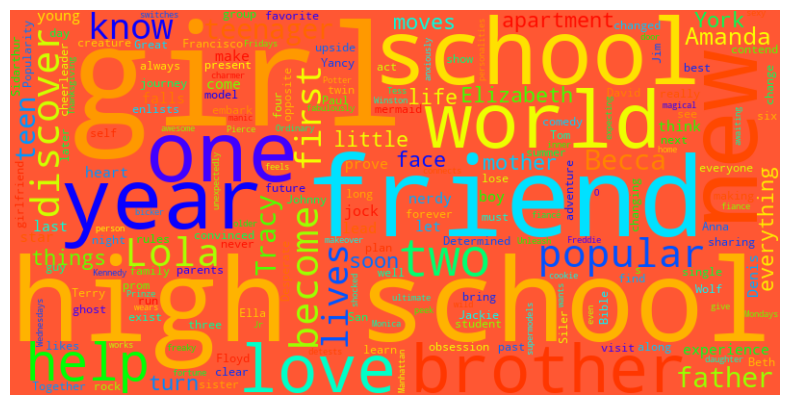

title  vote_count  vote_average  year  \
3311                          Head Over Heels        73.0           5.3  2001   
4735                            Freaky Friday       919.0           6.0  2003   
1321                         The House of Yes        30.0           6.3  1997   
6245                         Just Like Heaven       595.0           6.5  2005   
7865                    Mr. Popper's Penguins       775.0           5.7  2011   
7292               Ghosts of Girlfriends Past       716.0           5.6  2009   
6923                The Spiderwick Chronicles       593.0           6.3  2008   
8855                                 The DUFF      1372.0           6.8  2015   
6662                    It's a Boy Girl Thing       279.0           6.3  2006   
7333                  I Love You, Beth Cooper       204.0           5.2  2009   
3696                     The Princess Diaries      1063.0           6.5  2001   
7450  American Pie Presents: The Book of Love       454.0           5.1  2009   
5510                                Sleepover       105.0           5.4  2004   
5135                     Just One of the Guys        64.0           6.4  1985   
5064                         Lord Love a Duck         8.0           4.9  1966   
1539                       The Breakfast Club      2189.0           7.8  1985   
1997                           She's All That       425.0           5.7  1999   
8812                    Men, Women & Children       323.0           6.4  2014   
5124     Confessions of a Teenage Drama Queen       228.0           5.1  2004   
7048  The Sisterhood of the Traveling Pants 2       244.0           6.1  2008   
7392                                 Reckless         4.0           5.8  1984   
7652                            Vampires Suck       326.0           4.2  2010   
4968                                Teen Wolf       292.0           6.0  1985   
6417                               Aquamarine       372.0           5.8  2006   
390                        Dazed and Confused       588.0           7.4  1993   

                                            description  
3311  Ordinary single girl Amanda Pierce (Monica Pot...  
4735  Mother and daughter bicker over everything -- ...  
1321  Jackie-O is anxiously awaiting the visit of he...  
6245  Shortly after David Abbott moves into his new ...  
7865  Jim Carrey stars as Tom Popper, a successful b...  
7292  When notorious womanizer Connor Mead attends h...  
6923  Upon moving into the run-down Spiderwick Estat...  
8855  Bianca's universe turns upside down when she l...  
6662  A visit to a natural history museum proves cat...  
7333  Nerdy teenager Denis Cooverman (Paul Rust) har...  
3696  A socially awkward but very bright 15-year-old...  
7450  Ten years after the first American Pie movie, ...  
5510  As their first year of high school looms ahead...  
5135  When Terry Griffith loses her high school's wr...  
5064  From his prison cell, young Alan Musgrave (Rod...  
1539  Five high school students, all different stere...  
1997  High school hotshot Zach Siler is the envy of ...  
8812  Follows the story of a group of high school te...  
5124  When the teenager Mary Elizabeth Steppe, a.k.a...  
7048  Four young women continue the journey toward a...  
7392  Rebellious footballer Johnny, falls for cheerl...  
7652  Becca, an anxious, non-vampire teen is torn be...  
4968  What's a high school kid got to do to be popul...  
6417  Two teenage girls discover that mermaids reall...  
390   The adventures of a group of Texas teens on th...

In [138]:
rl_improved_recommendations('Mean Girls')



Unfortunately, *Batman and Robin* still appears on our recommendation list, likely due to its TMDB rating of 4—just slightly below average. This rating seems undeserved, especially when outstanding movies like *The Dark Knight Rises* have only a 7. However, there’s not much we can do about this within our current content-based approach.

With that, we’ll conclude the Content-Based Recommender section for now and revisit it later when we build a **hybrid recommendation engine**.


### Collaborative Filtering

While our content-based engine is useful, it has significant drawbacks. Its recommendations are limited to movies that are similar to a specific title, meaning it lacks the ability to suggest movies across diverse genres. Moreover, the engine isn’t personalized—every user who queries the system with the same movie will receive identical recommendations, regardless of their individual tastes.

To overcome these limitations, we’ll introduce **Collaborative Filtering**. This method recommends movies based on the preferences of similar users, under the assumption that **people with similar tastes** are likely to enjoy similar movies. By leveraging the viewing patterns of like-minded users, we can create a more tailored recommendation experience.

Instead of building a Collaborative Filtering model from scratch, we’ll use the **Surprise** library, which incorporates advanced algorithms like **Singular Value Decomposition (SVD)**. These algorithms are optimized to minimize **Root Mean Square Error (RMSE)**, resulting in high-quality recommendations.


In [139]:
reader = Reader()



In [140]:
ratings = pd.read_csv('ratings_small.csv')
ratings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [142]:
# Load data
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Initialize the SVD algorithm
svd = SVD()

# Perform 5-fold cross-validation and evaluate with RMSE and MAE
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8872  0.8984  0.9022  0.8930  0.9038  0.8969  0.0061  
MAE (testset)     0.6820  0.6887  0.6938  0.6883  0.6969  0.6899  0.0051  
Fit time          0.65    0.75    0.73    0.73    0.78    0.73    0.04    
Test time         0.07    0.06    0.10    0.08    0.06    0.08    0.01    


We achieved a mean **Root Mean Square Error (RMSE)** of **0.8963**, which is highly satisfactory for our needs. Now, let’s train the model on our dataset and generate predictions.


In [143]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [144]:
ratings[ratings['userId'] == 1]



userId  movieId  rating   timestamp
0        1       31     2.5  1260759144
1        1     1029     3.0  1260759179
2        1     1061     3.0  1260759182
3        1     1129     2.0  1260759185
4        1     1172     4.0  1260759205
5        1     1263     2.0  1260759151
6        1     1287     2.0  1260759187
7        1     1293     2.0  1260759148
8        1     1339     3.5  1260759125
9        1     1343     2.0  1260759131
10       1     1371     2.5  1260759135
11       1     1405     1.0  1260759203
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
14       1     2150     3.0  1260759194
15       1     2193     2.0  1260759198
16       1     2294     2.0  1260759108
17       1     2455     2.5  1260759113
18       1     2968     1.0  1260759200
19       1     3671     3.0  1260759117

In [145]:
svd.predict(1, 302, 3)



Prediction(uid=1, iid=302, r_ui=3, est=2.565968348727316, details={'was_impossible': False})

### Collaborative Filtering Insight

For the movie with **ID 302**, our model predicts an estimated rating of **2.566**. 

One fascinating aspect of this collaborative filtering system is that it’s entirely **content-agnostic**. The model doesn’t consider the movie's title, genre, cast, or any other features. Instead, it relies solely on the movie’s ID and the patterns in user ratings, using similar users’ preferences to make its predictions. This approach highlights the power of collaborative filtering in capturing user tastes purely from viewing behavior.


### Hybrid Recommender

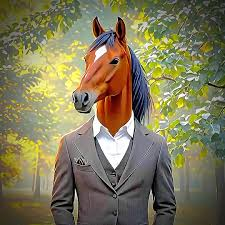

In this section, we’ll build a straightforward **hybrid recommender** that combines the strengths of both content-based and collaborative filtering approaches. Here’s how it works:

- **Input**: A **User ID** and the **Title** of a Movie
- **Output**: A list of similar movies, ranked by the expected rating for that specific user.

By merging these two techniques, our hybrid model can deliver more personalized recommendations that account for both the movie’s characteristics and the unique preferences of each user.



In [146]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [148]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
#id_map = id_map.set_index('tmdbId')



In [149]:
indices_map = id_map.set_index('id')



In [156]:
import matplotlib.pyplot as plt
import numpy as np

def hybrid(userId, title):
    # Get the index and metadata for the specified movie title
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']
    
    # Calculate similarity scores and select the top 25 similar movies
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    # Create a DataFrame of similar movies with their metadata and predicted ratings
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False).head(10)
    
    # Plot the bubble chart for the top recommendations
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        x=movies['vote_average'], 
        y=movies['est'], 
        s=movies['vote_count'] * 10,  # Scale up bubble size for visibility
        c=movies['est'],  # Color bubbles based on predicted rating
        cmap='viridis',  # Use the viridis colormap
        alpha=0.7,  # Set transparency
        edgecolors="w", linewidth=2
    )
    plt.colorbar(scatter, label="Predicted Rating (est)")
    plt.xlabel("Vote Average")
    plt.ylabel("Predicted Rating (est)")
    plt.title(f"Top Recommended Movies using Hybrid model for {title} - Bubble Chart")
    
    # Annotate each bubble with the movie title
    for i, row in movies.iterrows():
        plt.text(row['vote_average'], row['est'], row['title'], fontsize=9, ha='right', alpha=0.4)
    
    plt.show()
    
    # Return the recommendations as a DataFrame
    return movies


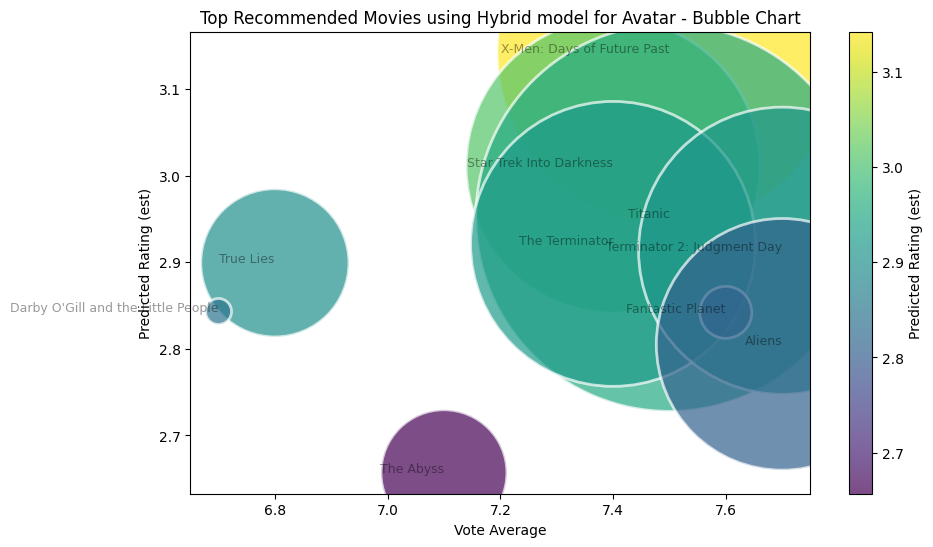

title  vote_count  vote_average  year  \
8622          X-Men: Days of Future Past      6155.0           7.5  2014   
8357             Star Trek Into Darkness      4479.0           7.4  2013   
1368                             Titanic      7770.0           7.5  1997   
999                       The Terminator      4208.0           7.4  1984   
522           Terminator 2: Judgment Day      4274.0           7.7  1991   
344                            True Lies      1138.0           6.8  1994   
1613  Darby O'Gill and the Little People        35.0           6.7  1959   
2006                    Fantastic Planet       140.0           7.6  1973   
962                               Aliens      3282.0           7.7  1986   
910                            The Abyss       822.0           7.1  1989   

          id       est  
8622  127585  3.142202  
8357   54138  3.011406  
1368     597  2.951463  
999      218  2.921296  
522      280  2.913405  
344    36955  2.899382  
1613   18887  2.843189  
2006   16306  2.842185  
962      679  2.805245  
910     2756  2.656879

In [157]:
hybrid(1, 'Avatar')



With our hybrid recommender, we observe that **different users receive unique recommendations** even when starting from the same movie. This personalization ensures that recommendations are more accurately **tailored to each individual’s preferences**, providing a more customized experience.


### Conclusion

In this project, I developed four distinct recommendation engines, each leveraging different algorithms and strategies to deliver movie recommendations. Here’s a summary of the approaches we implemented:

1. **Simple Recommender**: This engine used TMDB’s overall **Vote Count** and **Vote Averages** to create charts for top movies, both across genres and within specific genres. We used the IMDB **Weighted Rating System** to rank movies, ensuring that the final list prioritized high-quality films.

2. **Content-Based Recommender**: We created two content-based engines—one that analyzed **movie overviews and taglines** and another that used **metadata** such as cast, crew, genre, and keywords. Additionally, we applied a filter to give greater weight to movies with higher ratings and more votes, enhancing the recommendations' reliability.

3. **Collaborative Filtering**: Leveraging the **Surprise Library**, we built a collaborative filtering engine powered by **Singular Value Decomposition (SVD)**. This model achieved an RMSE of less than 1, providing accurate estimated ratings for a given user and movie pair.

4. **Hybrid Engine**: Combining the strengths of content-based and collaborative filtering methods, this hybrid engine generated personalized recommendations for each user based on their unique preferences. By estimating ratings internally for specific users, it provided tailored suggestions.

Finally, we introduced an **RL-enhanced model** that dynamically adjusts system resources using a **Reinforcement Learning (RL) agent**. This approach optimizes factors like CPU usage and batch size based on real-time feedback, improving system efficiency, reducing latency, and delivering a faster, more adaptive recommendation experience.

Through these models, we’ve explored a variety of recommendation strategies, each with unique strengths. Together, they demonstrate the powerful possibilities of personalized recommendation systems, paving the way for further enhancements in adaptive and user-centered movie recommendations.
